# Local response to mesoscale SST anomalies in IFS-AMIP experiments

**Contributors**: Chris Roberts (ECMWF), Matthias Aengenheyster (ECMWF)

This notebook illustrates a method to evaluate the *local* atmospheric response to high-pass filtered mesoscale SST anomalies.

The method can be summarized as follows: 

* Calculate daily SST anomalies relative to daily climatology.
* High-pass filter SST anomalies to isolate transient mesoscale features (including eddies). 
* Calculate local thresholds for warm/cool "eddies" using p.d.f. of high-pass filtered SST data (e.g. using terciles).
* Composite fields using the dates corresponding to warm/cool "eddies" in the high-pass filtered SST to evaluate local response.

Note that composites for each grid-point will represent a different set of dates and thus this method only provides information about the local response to warm/cool eddy conditions. However, the composites provide spatial information which is complementary to the information available from composites constructed from lagrangian eddy tracks and can be applied to coupled simulations, AMIP simulations, and observations. 

Here we illustrate the method applied to two IFS-AMIP simulations, which are atmosphere-only experiments with a prescribed sea surface temperature (SST) and sea-ice concentration (SIC). These are preliminary experiments designed to study the impact of transient mesoscale SST features on the atmosphere. The experiment *amip-hist-obs* is forced with observed SST and SIC, taken from the high-resolution OSTIA dataset (also available under #OBSERVATIONS). The twin experiment *amip-hist-obs-lr30* is identical except that observed SST *anomalies* are smoothed out with a filter the length scale of which is a multiple of the local Rossby radius of deformation. 

| Run                | Data        |  SST
|--------------------|-------------|-----------|
| amip-hist-obs      | 2010 - 2020 | unfiltered OSTIA SST
| amip-hist-obs-lr30 | 2010 - 2020 | OSTIA SST anomalies smoothed with 30 x Rossby radius


In this notebook, the local response to mesoscale SST anomalies during the DJF season is presented two different ways: 

* *X*$_{WarmEddy}$ - *X*$_{CoolEddy}$: Shows the differences in the composite mean of *X* in *amip-hist-obs* during local warm eddy minus local cool eddy conditions. In this case, the composite means for warm and cool eddy conditions reflect different dates within the 11 year period. 

* *X*$_{WarmEddy}$ - *X*$_{NoEddy}$: Shows the differences in the composite mean of *X* for warm eddy conditions in *amip-hist-obs* minus the composite mean calculated from *amip-hist-obs-lr30*, from which the warm-eddy features have been removed from the SST boundary condition. In this case the composites are calculated using the same dates at each grid point.

* *X*$_{CoolEddy}$ - *X*$_{NoEddy}$: Shows the differences in the composite mean of *X* for cool eddy conditions in *amip-hist-obs* minus the composite mean calculated from *amip-hist-obs-lr30*, from which the cool-eddy features have been removed from the SST boundary condition. In this case the composites are calculated using the same dates at each grid point.

In [ ]:
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar

In [2]:
# Utility functions
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")

In [3]:
# Open intake catalog for specified model data
yaml_path = "https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml"
platform = "dkrz"
location = "disk"
data_type = "model-output"
model = "ifs-amip"
catalog = intake.open_catalog(yaml_path)[platform][location][data_type][model]

In [4]:
# Lazy-load dask arrays for each experiment
eddy_exp = "amip-hist-obs.atmos.gr025"
no_eddy_exp = "amip-hist-obs-lr30.atmos.gr025"
eddy_6h = ifs_to_latlon(catalog[eddy_exp]["2D_6h_0.25deg"].to_dask())
no_eddy_6h = ifs_to_latlon(catalog[no_eddy_exp]["2D_6h_0.25deg"].to_dask())

In [5]:
# Define region - e.g. 
season = "DJF"
min_step = 1 # Do not use step=0 as accumulated fluxes are zero.
max_step = None
min_lon = 140
max_lon = 190
min_lat = 20
max_lat = 55

In [6]:
# Select data region
eddy_region = eddy_6h.isel(
    time=slice(min_step, max_step),
).sel(
    lat=slice(min_lat, max_lat),
    lon=slice(min_lon, max_lon),
)
no_eddy_region = no_eddy_6h.isel(
    time=slice(min_step, max_step),
).sel(
    lat=slice(min_lat, max_lat),
    lon=slice(min_lon, max_lon),
)

In [7]:
# Select season
eddy_season = eddy_region.sel(time=eddy_region["time.season"] == season)
no_eddy_season = no_eddy_region.sel(time=eddy_region["time.season"] == season)

In [24]:
# Select variables and calculate daily means
with ProgressBar():
    eddy_sst = eddy_season["sst"].groupby("time.date").mean(dim="time").compute()
    eddy_slhf = eddy_season["slhf"].groupby("time.date").mean(dim="time").compute()
    eddy_tp = eddy_season["tp"].groupby("time.date").mean(dim="time").compute()
    no_eddy_sst = no_eddy_season["sst"].groupby("time.date").mean(dim="time").compute()
    no_eddy_slhf = no_eddy_season["slhf"].groupby("time.date").mean(dim="time").compute()
    no_eddy_tp = no_eddy_season["tp"].groupby("time.date").mean(dim="time").compute()


[########################################] | 100% Completed | 15.99 s
[########################################] | 100% Completed | 13.08 s
[########################################] | 100% Completed | 15.13 s
[########################################] | 100% Completed | 15.49 s
[########################################] | 100% Completed | 13.46 s
[########################################] | 100% Completed | 13.40 s


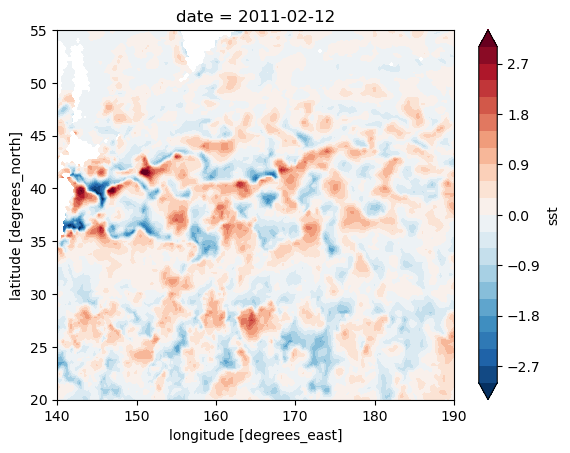

In [14]:
# High-pass filtered SST anomalies can be recovered as difference between experiments  
sst_diff = eddy_sst - no_eddy_sst
# Plot high-pass filtered anomalies for a random day
xr.plot.contourf(sst_diff.isel(date=132), levels=np.linspace(-3,3,21)) 

In [17]:
# Calculate tercile boundaries from high-pass filtered anomalies
upper_tercile = 0.66667
lower_tercile = 0.33333
sst_diff_terciles = sst_diff.quantile([lower_tercile, upper_tercile], dim="date")

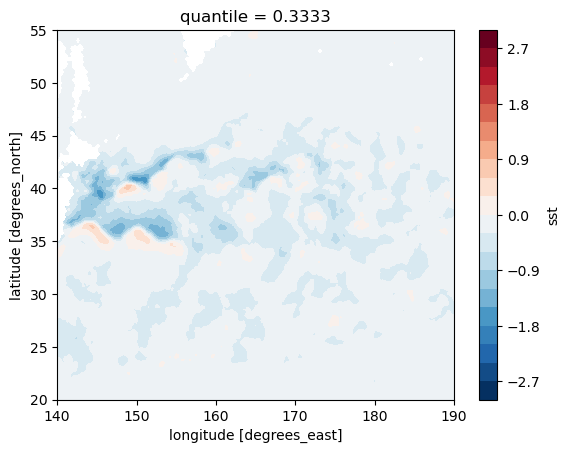

In [18]:
# Plot lower tercile for high-pass filtered SST anomaly 
xr.plot.contourf(sst_diff_terciles.sel(quantile=lower_tercile), levels=np.linspace(-3,3,21))

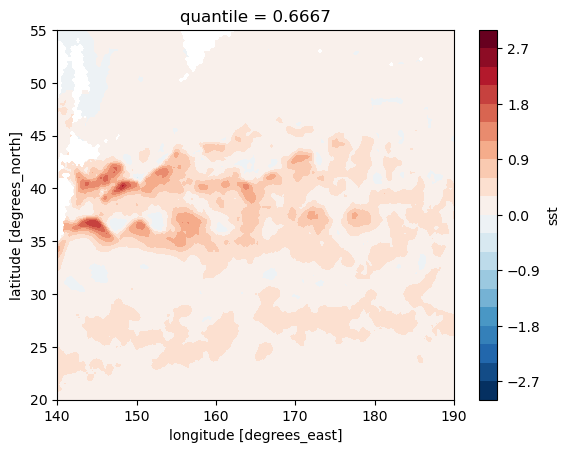

In [19]:
# Plot upper tercile for high-pass filtered SST anomaly 
xr.plot.contourf(sst_diff_terciles.sel(quantile=upper_tercile), levels=np.linspace(-3,3,21))

In [21]:
# Create masks for composites 
def calc_composite(da, mask):
    """ Efficiently calculate composites using 3D mask. """ 
    return (da * mask).sum(dim="date") / mask.sum(dim="date")

mask_upper = (sst_diff > sst_diff_terciles.sel(quantile=upper_tercile)) * 1.0 # Coerce to float - not sure why da.astype() not working.
mask_lower = (sst_diff < sst_diff_terciles.sel(quantile=lower_tercile)) * 1.0

Text(0.5, 1.0, 'SST$_{CoolEddy}$-SST$_{NoEddy}$ (K)')

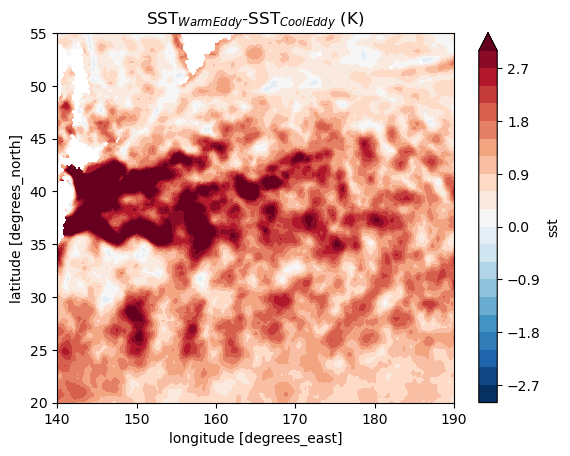

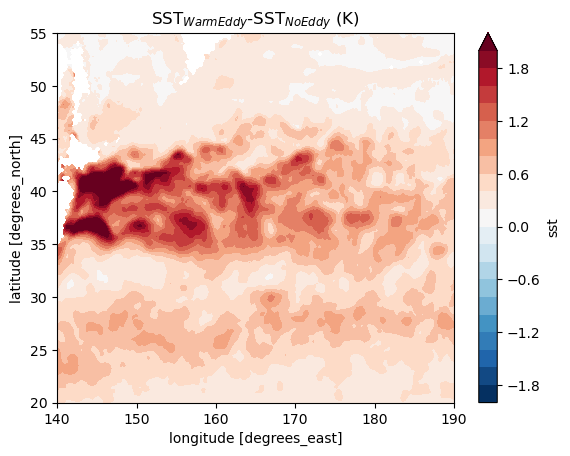

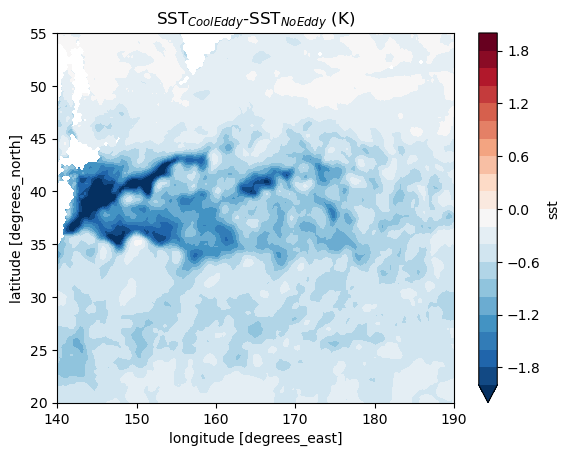

In [22]:
# SST composites
eddy_sst_upper = calc_composite(eddy_sst, mask_upper)
no_eddy_sst_upper = calc_composite(no_eddy_sst, mask_upper)
eddy_sst_lower = calc_composite(eddy_sst, mask_lower)
no_eddy_sst_lower = calc_composite(no_eddy_sst, mask_lower)
xr.plot.contourf(eddy_sst_upper-eddy_sst_lower, levels=np.linspace(-3,3,21))
plt.title("SST$_{WarmEddy}$-SST$_{CoolEddy}$ (K)")
plt.figure()
xr.plot.contourf(eddy_sst_upper-no_eddy_sst_upper, levels=np.linspace(-2,2,21))
plt.title("SST$_{WarmEddy}$-SST$_{NoEddy}$ (K)")
plt.figure()
xr.plot.contourf(eddy_sst_lower-no_eddy_sst_lower,levels=np.linspace(-2,2,21))
plt.title("SST$_{CoolEddy}$-SST$_{NoEddy}$ (K)")


Text(0.5, 1.0, 'Precip$_{CoolEddy}$-Precip$_{NoEddy}$ (mm/day)')

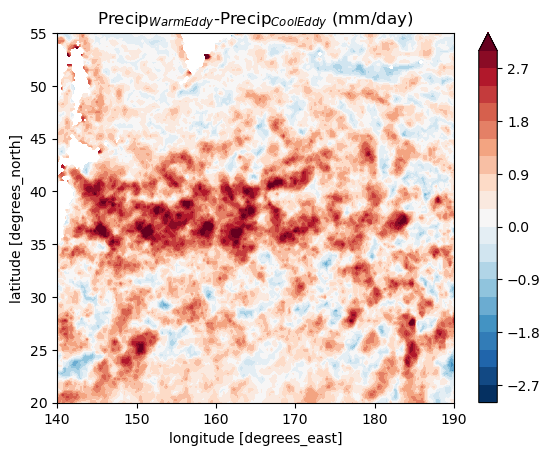

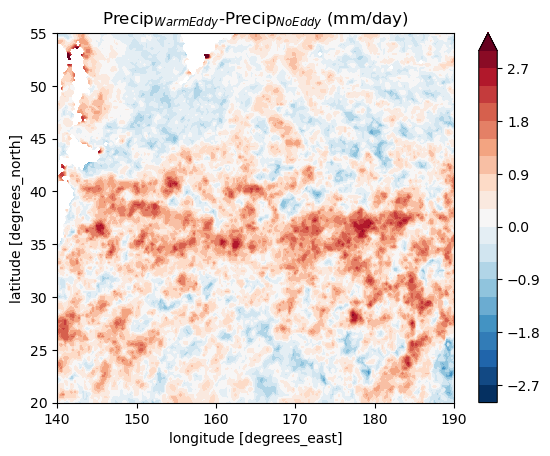

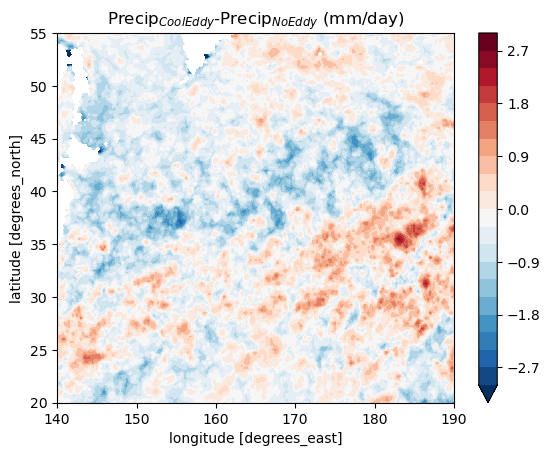

In [25]:
# Precip composites
eddy_tp_upper = calc_composite(eddy_tp, mask_upper) * 4000. # mm/day
no_eddy_tp_upper = calc_composite(no_eddy_tp, mask_upper) * 4000. # mm/day
eddy_tp_lower = calc_composite(eddy_tp, mask_lower) * 4000. # mm/day
no_eddy_tp_lower = calc_composite(no_eddy_tp, mask_lower) * 4000. # mm/day
xr.plot.contourf(eddy_tp_upper-eddy_tp_lower, levels=np.linspace(-3,3,21))
plt.title("Precip$_{WarmEddy}$-Precip$_{CoolEddy}$ (mm/day)")
plt.figure()
xr.plot.contourf(eddy_tp_upper-no_eddy_tp_upper, levels=np.linspace(-3,3,21))
plt.title("Precip$_{WarmEddy}$-Precip$_{NoEddy}$ (mm/day)")
plt.figure()
xr.plot.contourf(eddy_tp_lower-no_eddy_tp_lower, levels=np.linspace(-3,3,21))
plt.title("Precip$_{CoolEddy}$-Precip$_{NoEddy}$ (mm/day)")

Text(0.5, 1.0, 'LHF$_{CoolEddy}$-LHF$_{NoEddy}$ (m/s)')

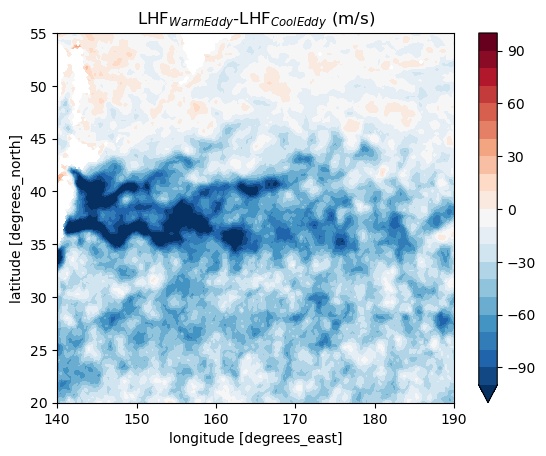

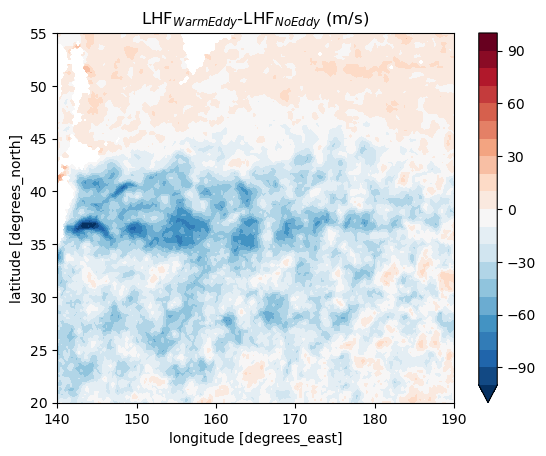

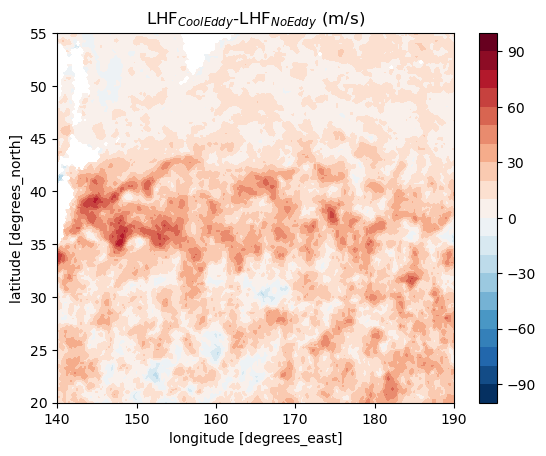

In [26]:
# Latent heat flux composites
unit_conversion = (1. / (6*60.*60.)) # Convert from joules per m2 per 6h to W/m2
eddy_slhf_upper = calc_composite(eddy_slhf, mask_upper) * unit_conversion
no_eddy_slhf_upper = calc_composite(no_eddy_slhf, mask_upper) * unit_conversion
eddy_slhf_lower = calc_composite(eddy_slhf, mask_lower) * unit_conversion
no_eddy_slhf_lower = calc_composite(no_eddy_slhf, mask_lower) * unit_conversion
xr.plot.contourf(eddy_slhf_upper-eddy_slhf_lower, levels=np.linspace(-100,100,21))
plt.title("LHF$_{WarmEddy}$-LHF$_{CoolEddy}$ (m/s)")
plt.figure()
xr.plot.contourf(eddy_slhf_upper-no_eddy_slhf_upper, levels=np.linspace(-100,100,21))
plt.title("LHF$_{WarmEddy}$-LHF$_{NoEddy}$ (m/s)")
plt.figure()
xr.plot.contourf(eddy_slhf_lower-no_eddy_slhf_lower, levels=np.linspace(-100,100,21))
plt.title("LHF$_{CoolEddy}$-LHF$_{NoEddy}$ (m/s)")